In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip,  RandomBrightnessContrast
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, BatchNormalization, Bidirectional, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, ZeroPadding2D,ConvLSTM2D,LSTM,GlobalAveragePooling2D, Reshape, Dense, Multiply, AveragePooling2D, UpSampling2D
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate,TimeDistributed, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications import InceptionResNetV2, DenseNet121, MobileNetV2,ResNet50,VGG16,VGG19, NASNetLarge,EfficientNetB7,EfficientNetV2S, EfficientNetV2M,EfficientNetV2L
from tensorflow.keras.metrics import Recall, Precision, Accuracy, MeanIoU
from tensorflow.keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def focal_loss(y_true, y_pred):
    alpha=0.25
    gamma=2
    def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))
    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

In [ ]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS=3
EPOCHS = 55
BATCH = 4
LR = 0.0001
shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
PATH = "/content/drive/MyDrive/Fydp-2/Dataset/BUS/"

def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
# 1. Load the dataset
# 2. Use the albumentations library to augment the dataset.

import os
import cv2
from tqdm import tqdm
from glob import glob
from albumentations import CenterCrop, RandomRotate90, RGBShift,ShiftScaleRotate, GridDistortion,RandomGamma, HorizontalFlip,RandomBrightnessContrast, RandomBrightness, VerticalFlip, Transpose, Compose, HueSaturationValue, RandomContrast
from albumentations.augmentations.transforms import CLAHE, GaussNoise, FancyPCA

def load_data(path):
    images = sorted(glob(os.path.join(path, "original/*")))
    masks = sorted(glob(os.path.join(path, "GT/*")))
    return images, masks

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def augment_data(images, masks, save_path, augment=True):
    H = 256
    W = 256

    for x, y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")
        """ Extracting the name and extension of the image and the mask. """
        image_name = name[0]
        image_extn = name[1]

        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]

        """ Reading image and mask. """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        """ Augmentation """
        if augment == True:
            #aug = CenterCrop(200, 200, p=1.0)
            #augmented = aug(image=x, mask=y)
            #x1 = augmented["image"]
            #y1 = augmented["mask"]

            aug = RandomRotate90(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            aug = RandomRotate90(p=0.5)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            aug = GridDistortion(p=1.0)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x5 = augmented['image']
            y5 = augmented['mask']

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x6 = augmented['image']
            y6 = augmented['mask']

            aug = Transpose(p=1.0)
            augmented = aug(image=x, mask=y)
            x7 = augmented['image']
            y7 = augmented['mask']

            aug = Compose([VerticalFlip(p=0.5),RandomRotate90(p=0.5)])
            augmented = aug(image=x, mask=y)
            x8 = augmented['image']
            y8 = augmented['mask']

            aug = RandomBrightnessContrast(p=1)
            augmented = aug(image=x, mask=y)
            x9 = augmented['image']
            y9 = augmented['mask']

            aug = RandomGamma(p=1)
            augmented = aug(image=x, mask=y)
            x10 = augmented['image']
            y10 = augmented['mask']

            # aug = HueSaturationValue(p=1)
            # augmented = aug(image=x, mask=y)
            # x11 = augmented['image']
            # y11 = augmented['mask']

            aug = RGBShift(p=1)
            augmented = aug(image=x, mask=y)
            x12 = augmented['image']
            y12 = augmented['mask']

            # aug = RandomBrightness(p=1)
            # augmented = aug(image=x, mask=y)
            # x13 = augmented['image']
            # y13 = augmented['mask']

            # aug = RandomContrast(p=1)
            # augmented = aug(image=x, mask=y)
            # x14 = augmented['image']
            # y14 = augmented['mask']

            # aug = ShiftScaleRotate(p=0.5)
            # augmented = aug(image=x, mask=y)
            # x15 = augmented['image']
            # y15 = augmented['mask']

            # aug = Compose([VerticalFlip(p=0.7),RandomBrightness(p=0.5), RandomGamma(p=0.5)])
            # augmented = aug(image=x, mask=y)
            # x16 = augmented['image']
            # y16 = augmented['mask']

            clip_limit=6.0
            aug = CLAHE(clip_limit, p=1.0)
            augmented = aug(image=x, mask=y)
            x17 = augmented['image']
            y17 = augmented['mask']

            # alpha=1.0
            # aug = FancyPCA(alpha, p=1.0)
            # augmented = aug(image=x, mask=y)
            # x18 = augmented['image']
            # y18 = augmented['mask']

            # var_limit=(10.0, 50.0)
            # mean=-50
            # aug = GaussNoise(var_limit, mean, p=1.0)
            # augmented = aug(image=x, mask=y)
            # x18 = augmented['image']
            # y18 = augmented['mask']

            # clip_limit=5.0
            # aug = CLAHE(clip_limit, p=1.0)
            # augmented = aug(image=x, mask=y)
            # x19 = augmented['image']
            # y19 = augmented['mask']

            # aug = HueSaturationValue(p=0.5)
            # augmented = aug(image=x, mask=y)
            # x20 = augmented['image']
            # y20 = augmented['mask']

            # aug = RandomBrightnessContrast(p=0.7)
            # augmented = aug(image=x, mask=y)
            # x21 = augmented['image']
            # y21 = augmented['mask']

            # aug = RandomGamma(p=0.5)
            # augmented = aug(image=x, mask=y)
            # x22 = augmented['image']
            # y22 = augmented['mask']


            # save_images = [x]
            # save_masks =  [y]

            save_images = [x, x2, x3, x4, x5, x6, x7, x8, x9, x10, x12, x17]
            save_masks =  [y, y2, y3, y4, y5, y6, y7, y8, y9, y10, y12, y17]

            # save_images = [x, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18, x19, x20, x21, x22]
            # save_masks =  [y, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11, y12, y13, y14, y15, y16, y17, y18, y19, y20, y21, y22]

        else:
            save_images = [x]
            save_masks = [y]

        """ Saving the image and mask. """
        idx = 0
        for i, m in zip(save_images, save_masks):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))

            if len(images) == 1:
                tmp_img_name = f"{image_name}.{image_extn}"
                tmp_mask_name = f"{mask_name}.{mask_extn}"
            else:
                tmp_img_name = f"{image_name}_{idx}.{image_extn}"
                tmp_mask_name = f"{mask_name}_{idx}.{mask_extn}"

            image_path = os.path.join(save_path, "images", tmp_img_name)
            mask_path = os.path.join(save_path, "masks", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1

if __name__ == "__main__":
    """ Loading original images and masks. """
    path = "/content/drive/MyDrive/Fydp-2/Dataset/BUS/"
    images, masks = load_data(path)
    print(f"Original Images: {len(images)} - Original Masks: {len(masks)}")

    """ Creating folders. """
    create_dir("new_data/images")
    create_dir("new_data/masks")

    """ Applying data augmentation. """
    augment_data(images, masks, "new_data", augment=True)

    """ Loading augmented images and masks. """
    images, masks = load_data("new_data/")
    print(f"Augmented Images: {len(images)} - Augmented Masks: {len(masks)}")

Original Images: 163 - Original Masks: 163


100%|██████████| 163/163 [01:46<00:00,  1.52it/s]

Augmented Images: 0 - Augmented Masks: 0


In [ ]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "/content/new_data/images/*.png")))
    masks = sorted(glob(os.path.join(path, "/content/new_data/masks/*.png")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
# Previous preprocessing code

#def read_image(path):
#    path = path.decode()
#    x = cv2.imread(path, cv2.IMREAD_COLOR)
#    x = cv2.resize(x, (IMAGE_HEIGHT, IMAGE_WIDTH))
#    x = x/255.0
#    return x

# def read_mask(path):
#     path = path.decode()
#     x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#     x = cv2.resize(x, (IMAGE_HEIGHT, IMAGE_WIDTH))
#     x = x/255.0
#     x = np.expand_dims(x, axis=-1)
#     return x

# def tf_parse(x, y):
#     def _parse(x, y):
#         x = read_image(x)
#         y = read_mask(y)
#         return x, y

#     x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
#     x.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, 3])
#     y.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, 2])
#     return x, y

# def tf_dataset(x, y, batch=4):
#     dataset = tf.data.Dataset.from_tensor_slices((x, y))
#     dataset = dataset.map(tf_parse)
#     dataset = dataset.batch(batch)
#     dataset = dataset.repeat()
#     return dataset

In [ ]:
# # New preprocessing code # #

def read_image(x):
    x = x.decode()
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = np.clip(image - np.median(image)+127, 0, 255)
    image = image/255.0
    image = image.astype(np.float32)
    return image

def read_mask(y):
    y = y.decode()
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = mask/255.0
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

def parse_data(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        y = np.concatenate([y, y], axis=-1)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([256, 256, 3])
    y.set_shape([256, 256, 2])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=32)
    dataset = dataset.map(map_func=parse_data)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch)
    return dataset

In [ ]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  1566
Validation data:  195
Testing data:  195


In [ ]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

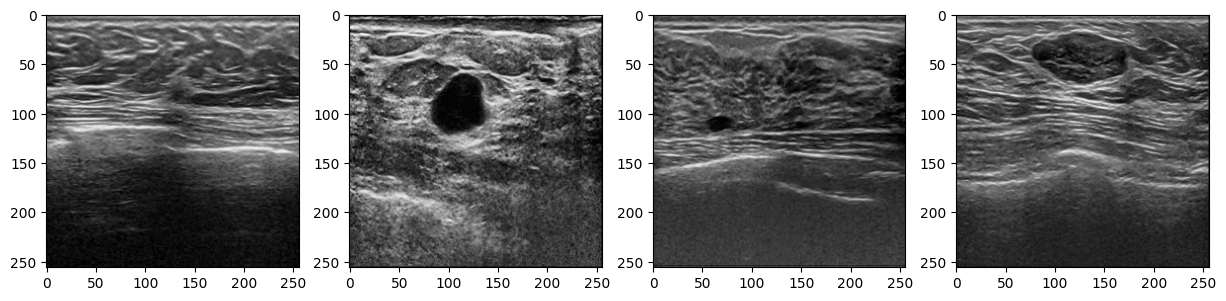

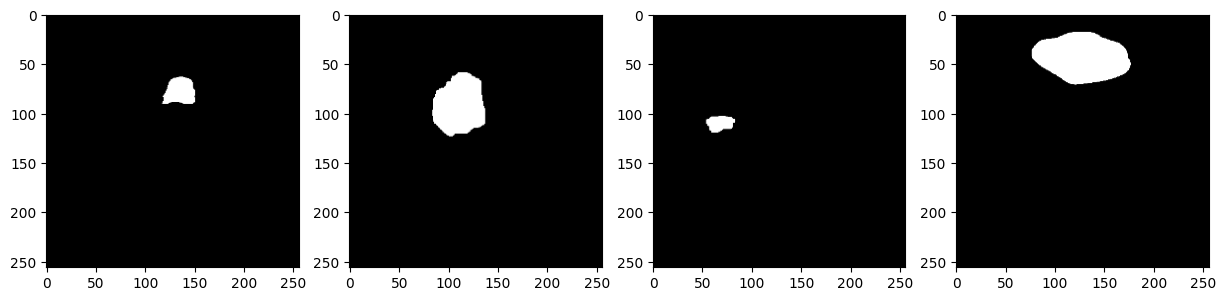

In [ ]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[1]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[10]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[61]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[9]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[1]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[10]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[61]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[9]))
imgplot.set_clim(0.0, 1.4)

In [ ]:
#inputs = tf.keras.layers.Input((IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
#enet = MobileNetV2(include_top=False, weights="imagenet", input_tensor=inputs)
#enet.summary()

In [ ]:
create_dir("files")
model_path = os.path.join("files", "BUS_Attention.hdf5")
csv_path = os.path.join("files", "BUS_Attention.csv")

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model


def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)

    return out * s

def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

def attention_unet(input_shape):
    """ Inputs """
    inputs = L.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    b1 = conv_block(p3, 512)

    """ Decoder """
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    """ Outputs """
    outputs = L.Conv2D(2, 1, padding="same", activation="sigmoid")(d3)

    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return model

if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = attention_unet(input_shape)
    model.summary()

Model: "Attention-UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                    

In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

opt = tf.keras.optimizers.Nadam(LR)
metrics = ['accuracy', dice_coef, Recall(), Precision(), iou, MeanIoU(num_classes=2)]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10),
    CSVLogger(csv_path),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)]

In [ ]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

hist=model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/55
392/392 [==============================] - 157s 296ms/step - loss: 0.6993 - accuracy: 0.7326 - dice_coef: 0.3007 - recall: 0.7244 - precision: 0.2913 - iou: 0.1845 - mean_io_u: 0.5382 - val_loss: 0.7602 - val_accuracy: 0.9369 - val_dice_coef: 0.2398 - val_recall: 0.4582 - val_precision: 0.3345 - val_iou: 0.1387 - val_mean_io_u: 0.5088 - lr: 1.0000e-04
Epoch 2/55
392/392 [==============================] - 119s 304ms/step - loss: 0.5124 - accuracy: 0.8916 - dice_coef: 0.4876 - recall: 0.6838 - precision: 0.5763 - iou: 0.3327 - mean_io_u: 0.5693 - val_loss: 0.4468 - val_accuracy: 0.9218 - val_dice_coef: 0.5532 - val_recall: 0.7958 - val_precision: 0.5658 - val_iou: 0.3943 - val_mean_io_u: 0.6579 - lr: 1.0000e-04
Epoch 3/55
392/392 [==============================] - 121s 309ms/step - loss: 0.3829 - accuracy: 0.9074 - dice_coef: 0.6171 - recall: 0.6701 - precision: 0.7110 - iou: 0.4588 - mean_io_u: 0.5860 - val_loss: 0.3310 - val_accuracy: 0.9416 - val_dice_coef: 0.6690 - val_rec

In [ ]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

49/49 [==============================] - 37s 776ms/step - loss: 0.0972 - accuracy: 0.5545 - dice_coef: 0.9028 - recall: 0.8452 - precision: 0.9714 - iou: 0.8331 - mean_io_u: 0.7818


[0.09717459231615067,
 0.5544692277908325,
 0.9028252363204956,
 0.8452153205871582,
 0.9714189767837524,
 0.833129346370697,
 0.781848669052124]

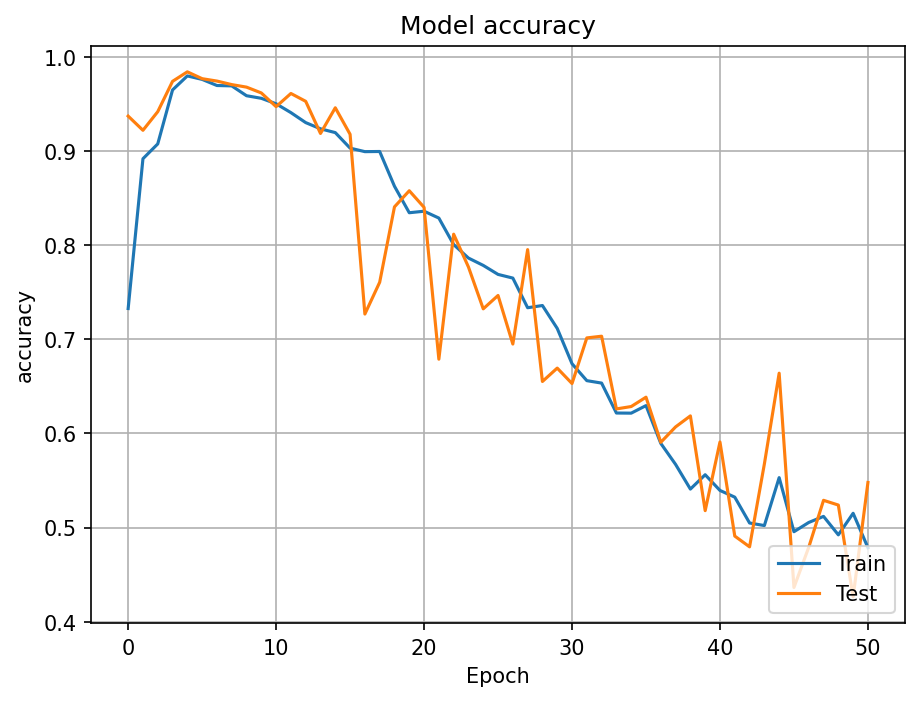

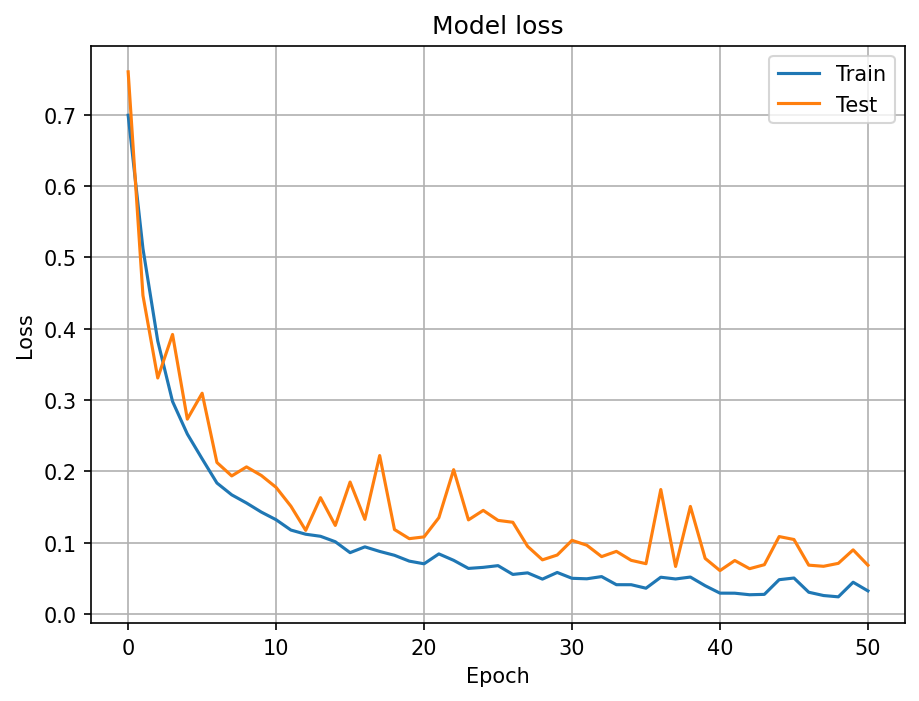

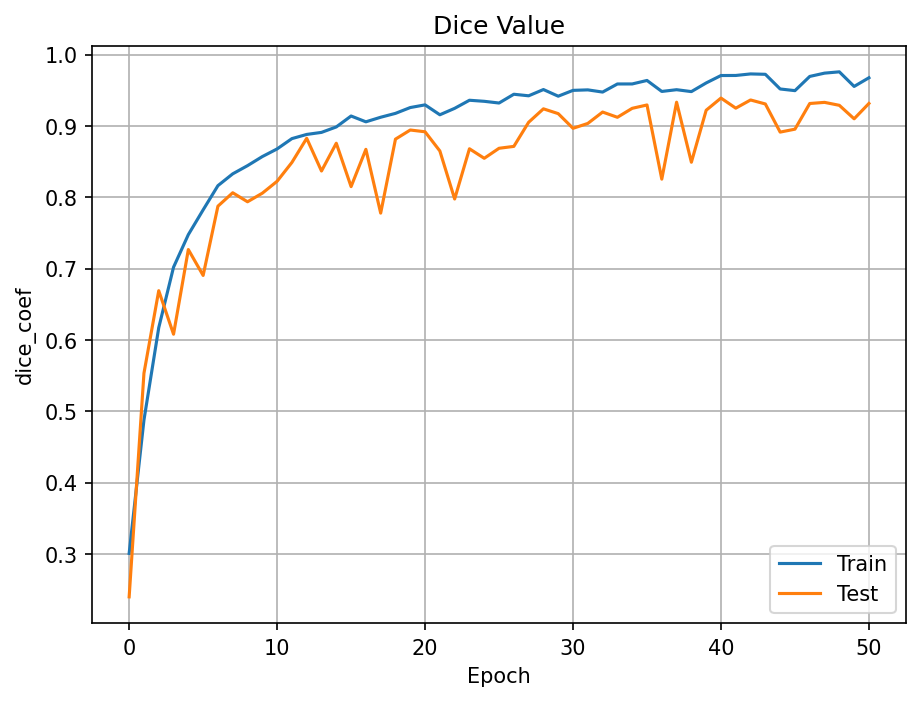

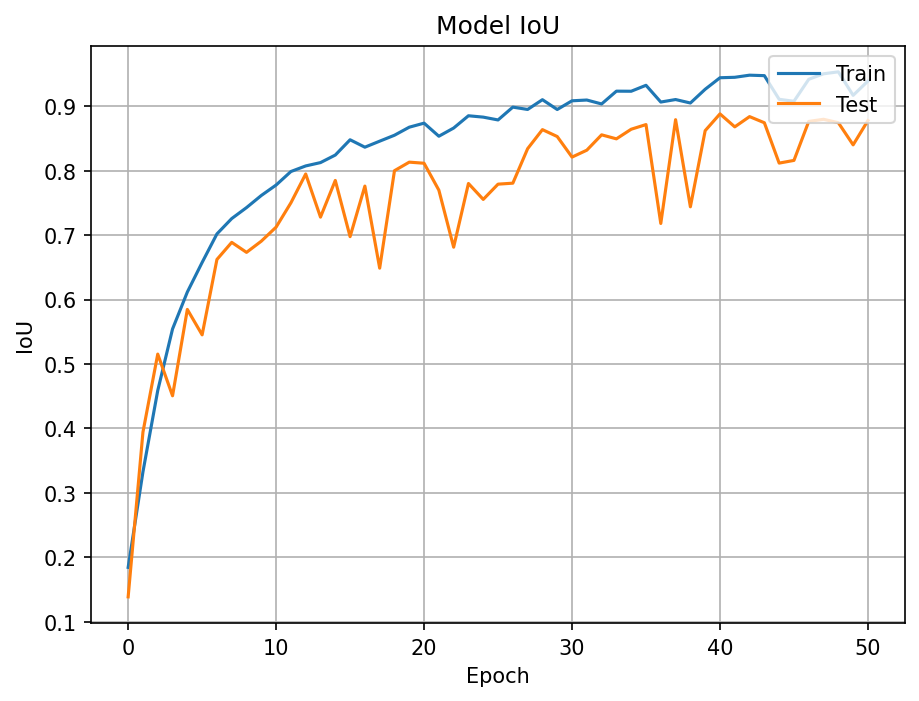

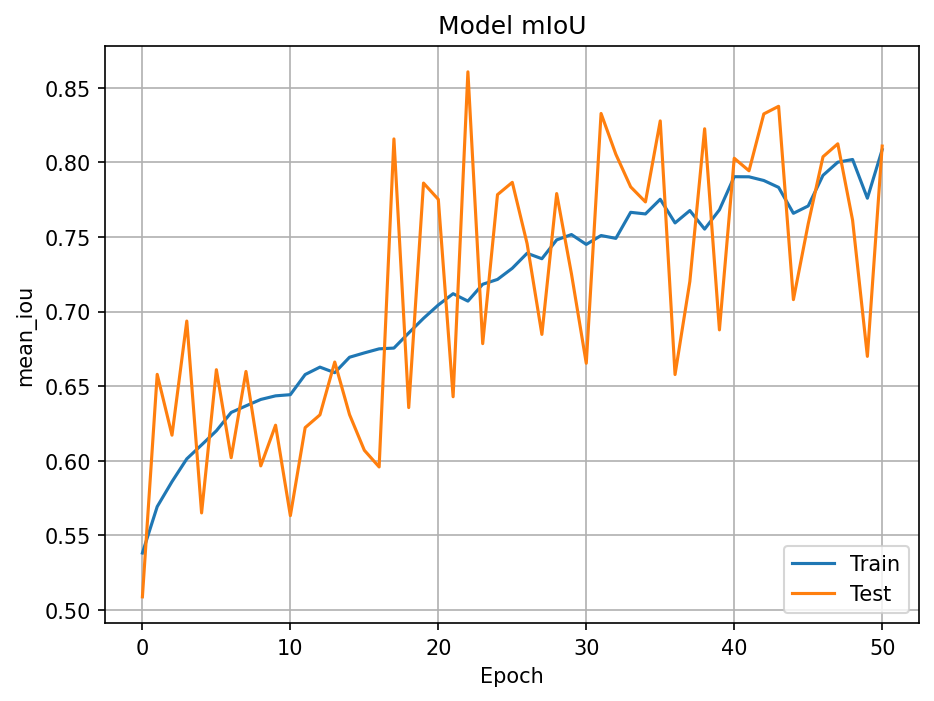

In [ ]:
# Plot training & validation loss values
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.grid('on')
plt.show()


# Plot training & validation loss values
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.grid('on')
plt.show()

# Plot training & validation accuracy values
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(hist.history['dice_coef'])
plt.plot(hist.history['val_dice_coef'])
plt.title('Dice Value')
plt.ylabel('dice_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.grid('on')
plt.show()


# Plot training & validation loss values
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(hist.history['iou'])
plt.plot(hist.history['val_iou'])
plt.title('Model IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.grid('on')
plt.show()


# Plot training & validation iou values
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(hist.history['mean_io_u'])
plt.plot(hist.history['val_mean_io_u'])
plt.title('Model mIoU')
plt.ylabel('mean_iou')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.grid('on')
plt.show()


In [ ]:
# # New code # #

def read_image(x):
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = np.clip(image - np.median(image)+127, 0, 255)
    image = image/255.0
    image = image.astype(np.float32)
    image = np.expand_dims(image, axis=0)
    return image

def read_mask(y):
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = mask.astype(np.float32)
    mask = mask/255.0
    mask = np.expand_dims(mask, axis=-1)
    return mask

def mask_to_3d(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

def parse(y_pred):
    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = y_pred[..., -1]
    y_pred = y_pred.astype(np.float32)
    y_pred = np.expand_dims(y_pred, axis=-1)
    return y_pred


In [ ]:
import os
import numpy as np
import cv2
import json
from glob import glob
#from metrics import *
from sklearn.utils import shuffle
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model
#from model import build_model, Upsample, ASPP

def create_dir(path):
    """ Create a directory. """
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print(f"Error: creating directory with name {path}")

def read_data(x, y):
    """ Read the image and mask from the given path. """
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    mask = cv2.imread(y, cv2.IMREAD_COLOR)
    return image, mask

def read_params():
    """ Reading the parameters from the JSON file."""
    with open("params.json", "r") as f:
        data = f.read()
        params = json.loads(data)
        return params

def load_data(path):
    """ Loading the data from the given path. """
    images_path = os.path.join(path, "image/*")
    masks_path  = os.path.join(path, "mask/*")

    images = glob(images_path)
    masks  = glob(masks_path)

    return images, masks

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_model_weight(path):
    with CustomObjectScope({
        'dice_loss': dice_loss,
        'dice_coef': dice_coef,
        'bce_dice_loss': bce_dice_loss,
        'focal_loss': focal_loss,
        'iou': iou
        }):
        model = load_model(path)
    return model
    # model = build_model(256)
    # model.load_weights(path)
    # return model

In [ ]:
model.save('/content/drive/MyDrive/Fydp-2/Dataset/BUS_Attention.hdf5')

In [ ]:
def create_dir(path):
    """ Create a directory. """
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print(f"Error: creating directory with name {path}")

def evaluate_normal(model, x_data, y_data):
    THRESHOLD = 0.5
    total = []
    for i, (x, y) in tqdm(enumerate(zip(x_data, y_data)), total=len(x_data)):
        x = read_image(x)
        y = read_mask(y)
        _, h, w, _ = x.shape

        y_pred1 = parse(model.predict(x)[0][..., -2])
        y_pred2 = parse(model.predict(x)[0][..., -1])

        line = np.ones((h, 10, 3)) * 255.0

        all_images = [
            x[0] * 255.0, line,
            mask_to_3d(y) * 255.0, line,
            mask_to_3d(y_pred1) * 255.0, line,
            mask_to_3d(y_pred2) * 255.0
        ]
        mask = np.concatenate(all_images, axis=1)

        #cv2.imwrite(f"results/{i}.png", mask)
        cv2.imwrite(f"/content/drive/MyDrive/Fydp-2/Dataset/BUS_Attention_Results/{i}.png", mask)

smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

if __name__ == "__main__":
    np.random.seed(42)
    tf.random.set_seed(42)
    #create_dir("results/")
    create_dir("/content/drive/MyDrive/Fydp-2/Dataset/BUS_Attention_Results/")

    batch_size = 4

    # test_path = "../1/new_data/test/"
    # test_x = sorted(glob(os.path.join(test_path, "image", "*.jpg")))
    # test_y = sorted(glob(os.path.join(test_path, "mask", "*.jpg")))
    test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

    test_steps = (len(test_x)//batch_size)
    if len(test_x) % batch_size != 0:
        test_steps += 1

    model = load_model_weight("/content/drive/MyDrive/Fydp-2/Dataset/BUS_Attention.hdf5")
    #model.evaluate(test_dataset, steps=test_steps)
    evaluate_normal(model, test_x, test_y)

  0%|          | 0/195 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 1/195 [00:01<05:43,  1.77s/it]

1/1 [==============================] - 0s 22ms/step


  1%|          | 2/195 [00:01<02:38,  1.22it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 3/195 [00:02<01:40,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 4/195 [00:02<01:12,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 5/195 [00:02<00:56,  3.35it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 6/195 [00:02<00:47,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 7/195 [00:02<00:41,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 8/195 [00:02<00:37,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 9/195 [00:03<00:38,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 10/195 [00:03<00:35,  5.23it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 11/195 [00:03<00:33,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 12/195 [00:03<00:32,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 13/195 [00:03<00:31,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 14/195 [00:03<00:31,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 15/195 [00:04<00:32,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 16/195 [00:04<00:32,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 17/195 [00:04<00:31,  5.60it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 18/195 [00:04<00:31,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 19/195 [00:04<00:34,  5.08it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 20/195 [00:05<00:35,  4.97it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 21/195 [00:05<00:35,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 22/195 [00:05<00:33,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 23/195 [00:05<00:32,  5.30it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 24/195 [00:05<00:31,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 25/195 [00:06<00:31,  5.44it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 26/195 [00:06<00:30,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 27/195 [00:06<00:31,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 28/195 [00:06<00:32,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 29/195 [00:06<00:31,  5.22it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 30/195 [00:06<00:31,  5.28it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 31/195 [00:07<00:30,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 32/195 [00:07<00:31,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 33/195 [00:07<00:32,  4.98it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 34/195 [00:07<00:32,  5.01it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 35/195 [00:08<00:35,  4.51it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 36/195 [00:08<00:38,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 37/195 [00:08<00:44,  3.54it/s]

1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 38/195 [00:09<00:48,  3.22it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 39/195 [00:09<00:50,  3.09it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 40/195 [00:09<00:49,  3.11it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 41/195 [00:10<00:49,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 42/195 [00:10<00:48,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 43/195 [00:10<00:47,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 44/195 [00:10<00:45,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 45/195 [00:11<00:43,  3.43it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 46/195 [00:11<00:41,  3.57it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 47/195 [00:11<00:37,  3.95it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 48/195 [00:11<00:35,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 49/195 [00:12<00:34,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 50/195 [00:12<00:31,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 51/195 [00:12<00:30,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 52/195 [00:12<00:30,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 53/195 [00:12<00:28,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 54/195 [00:13<00:29,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 55/195 [00:13<00:28,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 56/195 [00:13<00:28,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 57/195 [00:13<00:27,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 58/195 [00:13<00:26,  5.11it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 59/195 [00:14<00:26,  5.14it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 60/195 [00:14<00:27,  4.95it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 61/195 [00:14<00:26,  5.07it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 62/195 [00:14<00:26,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 63/195 [00:14<00:25,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 64/195 [00:15<00:24,  5.26it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 65/195 [00:15<00:24,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 66/195 [00:15<00:25,  5.12it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 67/195 [00:15<00:25,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 68/195 [00:15<00:24,  5.14it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 69/195 [00:16<00:25,  4.93it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 70/195 [00:16<00:25,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 71/195 [00:16<00:24,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 72/195 [00:16<00:24,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 73/195 [00:16<00:24,  5.08it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 74/195 [00:17<00:23,  5.18it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 75/195 [00:17<00:24,  4.94it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 76/195 [00:17<00:24,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 77/195 [00:17<00:24,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 78/195 [00:17<00:24,  4.75it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 79/195 [00:18<00:23,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 80/195 [00:18<00:22,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 81/195 [00:18<00:23,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 82/195 [00:18<00:23,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 83/195 [00:18<00:23,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 84/195 [00:19<00:22,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 85/195 [00:19<00:23,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 86/195 [00:19<00:22,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 87/195 [00:19<00:22,  4.90it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 88/195 [00:19<00:21,  5.03it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 89/195 [00:20<00:20,  5.11it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 90/195 [00:20<00:21,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 91/195 [00:20<00:20,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 92/195 [00:20<00:21,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 93/195 [00:20<00:20,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 94/195 [00:21<00:21,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 95/195 [00:21<00:20,  4.93it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 96/195 [00:21<00:21,  4.58it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 97/195 [00:21<00:23,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 98/195 [00:22<00:24,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 99/195 [00:22<00:24,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 100/195 [00:22<00:24,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 101/195 [00:23<00:25,  3.67it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 102/195 [00:23<00:25,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 103/195 [00:23<00:25,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 104/195 [00:23<00:25,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 105/195 [00:24<00:24,  3.74it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 106/195 [00:24<00:23,  3.84it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 107/195 [00:24<00:22,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 108/195 [00:24<00:23,  3.74it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 109/195 [00:25<00:22,  3.86it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 110/195 [00:25<00:20,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 111/195 [00:25<00:19,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 112/195 [00:25<00:18,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 113/195 [00:25<00:17,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 114/195 [00:26<00:17,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 115/195 [00:26<00:17,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 116/195 [00:26<00:16,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 117/195 [00:26<00:16,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 118/195 [00:26<00:15,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 119/195 [00:27<00:15,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 120/195 [00:27<00:15,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 121/195 [00:27<00:15,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 122/195 [00:27<00:15,  4.86it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 123/195 [00:27<00:14,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 124/195 [00:28<00:14,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 125/195 [00:28<00:14,  4.74it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 126/195 [00:28<00:14,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 127/195 [00:28<00:14,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 128/195 [00:29<00:14,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 129/195 [00:29<00:13,  4.74it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 130/195 [00:29<00:13,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 131/195 [00:29<00:12,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 132/195 [00:29<00:13,  4.73it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 133/195 [00:30<00:12,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 134/195 [00:30<00:13,  4.57it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 135/195 [00:30<00:12,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 136/195 [00:30<00:12,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 137/195 [00:30<00:12,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 138/195 [00:31<00:12,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 139/195 [00:31<00:11,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 140/195 [00:31<00:11,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 141/195 [00:31<00:11,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 142/195 [00:32<00:11,  4.46it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 143/195 [00:32<00:11,  4.69it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 144/195 [00:32<00:10,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 145/195 [00:32<00:10,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 146/195 [00:32<00:10,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 147/195 [00:33<00:10,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 148/195 [00:33<00:09,  4.91it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 149/195 [00:33<00:09,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 150/195 [00:33<00:09,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 151/195 [00:33<00:09,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 152/195 [00:34<00:08,  5.05it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 153/195 [00:34<00:08,  5.16it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 154/195 [00:34<00:08,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 155/195 [00:34<00:08,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 156/195 [00:34<00:08,  4.69it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 157/195 [00:35<00:08,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 158/195 [00:35<00:08,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 159/195 [00:35<00:09,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 160/195 [00:36<00:09,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 161/195 [00:36<00:09,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 162/195 [00:36<00:08,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 163/195 [00:36<00:08,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 164/195 [00:37<00:08,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 165/195 [00:37<00:08,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 166/195 [00:37<00:08,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 167/195 [00:38<00:08,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 168/195 [00:38<00:07,  3.48it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 169/195 [00:38<00:07,  3.53it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 170/195 [00:38<00:06,  3.88it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 171/195 [00:39<00:05,  4.08it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 172/195 [00:39<00:05,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 173/195 [00:39<00:05,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 174/195 [00:39<00:04,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 175/195 [00:39<00:04,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 176/195 [00:40<00:03,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 177/195 [00:40<00:03,  4.92it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 178/195 [00:40<00:03,  5.02it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 179/195 [00:40<00:03,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 180/195 [00:40<00:03,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 181/195 [00:41<00:02,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 182/195 [00:41<00:02,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 183/195 [00:41<00:02,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 184/195 [00:41<00:02,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 185/195 [00:41<00:02,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 186/195 [00:42<00:01,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 187/195 [00:42<00:01,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 188/195 [00:42<00:01,  4.63it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 189/195 [00:42<00:01,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 190/195 [00:42<00:01,  4.89it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 191/195 [00:43<00:00,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 192/195 [00:43<00:00,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 193/195 [00:43<00:00,  5.03it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 194/195 [00:43<00:00,  5.07it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 195/195 [00:43<00:00,  4.44it/s]
